# Serena Emotion Detector - Training Notebook

This notebook is used to setup and train Serena Emotion Detector in Vertex AI. The output will be saved to our GCS bucket `serena-shsw-datasets/models` folder.  
To evaluate the model, use `evaluate.ipynb` notebook in this directory.


## Background

Serena Emotion Detector is a CNN model that detects 7 emotions (`angry`, `disgust`, `fear`, `happy`, `neutral`, `sad`, `surprise`) from a person's front-facing photo. We use [FER2013](https://www.kaggle.com/deadskull7/fer2013) dataset since it is a popular dataset for emotion detection.

When we were starting with creating our model, we used to create the architecture from scratch. But after multiple trial and errors, the best we could get was around 64% accuracy. Even then, that took about 3 hours for every 10 epoch training session in Vertex AI. Other than that, our own models always faced problems where it would classify wrong emotions or would just be biased towards one emotion class.

After learning from our mistakes, learning more about CNN, and learning from tutorials; we decided to use transfer learning. We used transfer learning since it would be quicker to train and we don't have to design the architecture from scratch, instead we would just need to modify the dataset and some layers to fit our needs of detecting 7 classes of emotions.

The model we use for transfer learning is [MobileNetV2](https://www.ict-srilanka.com/blog/what-is-mobilenetv2). We use MobileNetV2 since it is designed to be lightweight for devices with limited resources (e.g. mobile phones, IoT devices, etc). We think this would make predictions quicker when deployed on Cloud Run or later in the future when we want to embed it directly into our IoT device `SerenBox`.


## Setup

We store our dataset in GCS. There are 7 classes, each class seperated into a folder. We'll save the model using the latest `.keras` instead of `.h5` since it's more modern and easier to move around since it will save the weight and model configuration in one file.  
If you want to try it out yourself, you need to replace `train_dataset_path` to your own FER-2013 dataset path. You can download FER-2013 dataset [here](https://www.kaggle.com/msambare/fer2013).

> 🚧 Warning
>
> This notebook was designed to be run in OUR Vertex AI environment. If you want to run it yourself, you need to change some code to fit your environment.  
> You can directly use our model without having to train it first by following the steps in `evaluate.ipynb` notebook.


Run this `gcsfuse` cell if you are using Vertex AI workbench and can't list the folders inside of "/gcs"

In [1]:
!gcsfuse --implicit-dirs "~/gcs"

I1212 09:58:15.978623 2023/12/12 09:58:15.978588 Start gcsfuse/0.42.5 (Go version go1.20.3) for app "" using mount point: /home/jupyter/gcs


In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers, Model
from keras.applications import MobileNetV2
from keras.callbacks import ModelCheckpoint

gcs_path = "/home/jupyter/gcs/serena-shsw-datasets/"
train_dataset_path = os.path.join(
    gcs_path, "FER-2013/train"  # TODO: change this to your own dataset
)
model_save_path = os.path.join(
    gcs_path,
    "models/serena-emotion-detector.keras",  # TODO: change this to your own path
)
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

2023-12-12 09:58:22.416780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:
2023-12-12 09:58:22.416832: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Processing Training Data


Read 40% of the images from each folder, convert them into numpy array, then append them into `training_data`. We only read 40% of the images since we keep running into memory limit errors even when using `n1-highmem-32` VM + 2 `NVIDIA_TESLA_T4` accelerators. We think this is due reshaping each image to 224x224 which is pretty big. But even with 40% of the data, we could still get accuracy of around 94% for the model.


In [3]:
from math import ceil

# There are 28709 images in the training set for FER-2013
train_dataset_total = 28709
sample_size = 0.40 * train_dataset_total
print("Sample size: ", sample_size)

training_data = []
img_size = 224
img_array = []

def stratified_sample_size_for_class(
    stratum_size, train_dataset_total=train_dataset_total, sample_size=sample_size
):
    return ceil(((sample_size / train_dataset_total) * stratum_size))

# Use this if memory is limited and you are getting sigkill errors
def create_training_data_stratified_sample():
    for category in classes:
        path = os.path.join(train_dataset_path, category)
        class_num = classes.index(category)
        stratum_size = len(os.listdir(path))
        sample_size = stratified_sample_size_for_class(stratum_size)
        print(
            "Class: ",
            category,
            "Stratum size: ",
            stratum_size,
            "Sample size: ",
            sample_size,
        )
        for img in os.listdir(path)[:sample_size]:
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

Sample size:  2870.9


In [4]:
create_training_data_stratified_sample()

Class:  angry Stratum size:  3995 Sample size:  400
Class:  disgust Stratum size:  436 Sample size:  44
Class:  fear Stratum size:  4097 Sample size:  410
Class:  happy Stratum size:  7215 Sample size:  722
Class:  neutral Stratum size:  4965 Sample size:  497
Class:  sad Stratum size:  4830 Sample size:  483
Class:  surprise Stratum size:  3171 Sample size:  318


In [5]:
print("Total training data size: ", len(training_data))

Total training data size:  2874


Randomize the training data to avoid bias


In [6]:
import random
random.shuffle(training_data)

Reshape training data to fit our model


In [7]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)
Y = np.array(y)

print(X.shape)
print(Y.shape)

(2874, 224, 224, 3)
(2874,)


Normalize the data


In [8]:
X = X / 255.0

## Creating Transfer Learning Model


Create pretrained model from `MobileNetV2`.


In [9]:
pretrained_model = MobileNetV2()
pretrained_model.summary()

2023-12-12 10:01:50.190667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:
2023-12-12 10:01:50.190733: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-12 10:01:50.190768: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emotion-detector-nb): /proc/driver/nvidia/version does not exist
2023-12-12 10:01:50.212328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Create new layers from the pretrained model.


In [10]:
input_layer = pretrained_model.layers[0].input
base_output_layer = pretrained_model.layers[-2].output

output_layer = layers.Dense(128)(base_output_layer)
output_layer = layers.Activation("relu")(output_layer)
output_layer = layers.Dense(64)(output_layer)
output_layer = layers.Activation("relu")(output_layer)
output_layer = layers.Dense(7, activation="softmax")(output_layer)

print(output_layer)

new_model = Model(
    inputs=input_layer,
    outputs=output_layer,
)
new_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), name='dense_2/Softmax:0', description="created by layer 'dense_2'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 1

In [11]:
new_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

## Train Model

Start training the model and saving the best model.

> 🚧 Warning
>
> DO NOT TRAIN DIRECTLY ON YOUR LOCAL COMPUTER, unless you have a really beefy computer with atleast 100GB of RAM. Why? Because the dataset is huge and it would take a loooonngggg time to train locally.
> To train, run `train.sh` to package this notebook and train it on Vertex AI using `n1-highmem-8` VM + 1 `NVIDIA_TESLA_T4` accelerator.


In [12]:
history = new_model.fit(X, Y, epochs=25)

2023-12-12 10:02:08.311931: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1730469888 exceeds 10% of free system memory.


Epoch 1/10
90/90 [==============================] - 269s 3s/step - loss: 1.5806 - accuracy: 0.3852
Epoch 2/10
90/90 [==============================] - 262s 3s/step - loss: 1.2948 - accuracy: 0.5143
Epoch 3/10
90/90 [==============================] - 265s 3s/step - loss: 1.1614 - accuracy: 0.5738
Epoch 4/10
90/90 [==============================] - 259s 3s/step - loss: 1.0332 - accuracy: 0.6159
Epoch 5/10
90/90 [==============================] - 260s 3s/step - loss: 0.9327 - accuracy: 0.6608
Epoch 6/10
90/90 [==============================] - 256s 3s/step - loss: 0.8133 - accuracy: 0.6962
Epoch 7/10
90/90 [==============================] - 261s 3s/step - loss: 0.7516 - accuracy: 0.7220
Epoch 8/10
90/90 [==============================] - 266s 3s/step - loss: 0.6337 - accuracy: 0.7693
Epoch 9/10
90/90 [==============================] - 258s 3s/step - loss: 0.5882 - accuracy: 0.7978
Epoch 10/10
90/90 [==============================] - 256s 3s/step - loss: 0.4873 - accuracy: 0.8225


In [ ]:
new_model.save(model_save_path)

## Evaluate Training Results


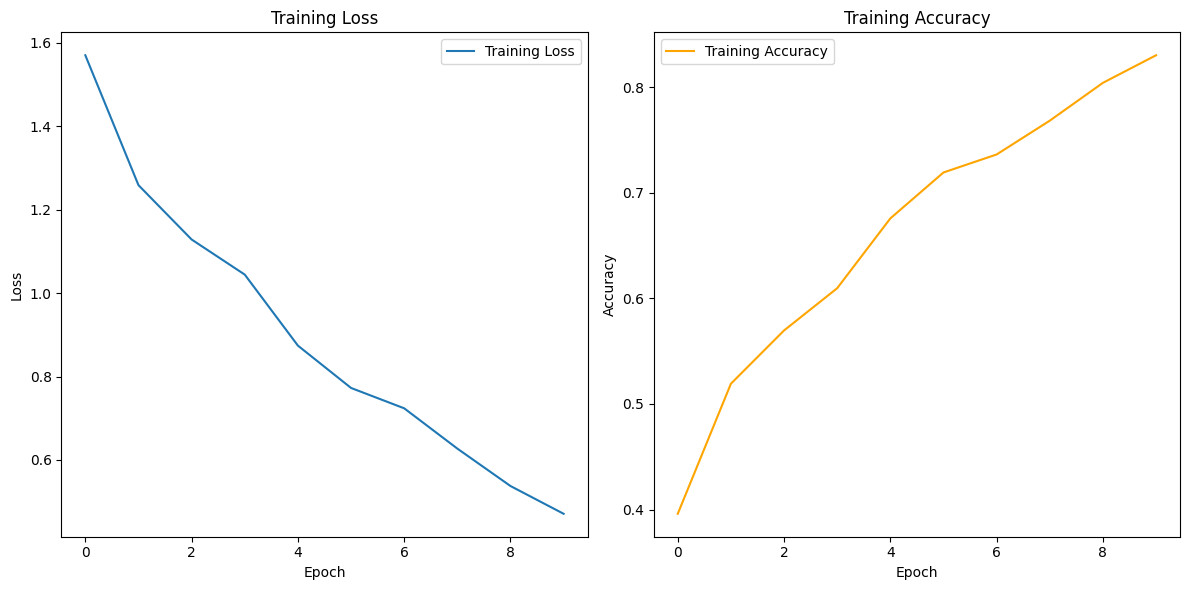

In [13]:
import matplotlib.pyplot as plt
# Mendapatkan data pelatihan (training) dari history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

# Membuat grafik untuk loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Membuat grafik untuk accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Menampilkan grafik
plt.tight_layout()
plt.show()
